In [2]:
from tensorflow import keras

In [3]:
from tensorflow.keras.datasets import mnist

In [4]:
from tensorflow.keras import layers

In [5]:
def get_mnist_model():
    inputs = keras.Input(shape=(28*28,))
    features = layers.Dense(512, activation='relu')(inputs)
    features = layers.Dropout(0.5)(features)
    output = layers.Dense(10, activation='softmax')(features)
    
    Model = keras.Model(inputs = inputs, outputs = output)
    return Model

In [6]:
(images , labels), (test_images, test_labels) = mnist.load_data()

In [7]:
### reshape images
images = images.reshape((60000, 28*28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28*28)).astype("float32") / 255

In [8]:
len(images)

60000

In [9]:
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

In [10]:
model = get_mnist_model()

In [11]:
model.compile(optimizer="rmsprop", 
     loss="sparse_categorical_crossentropy", 
     metrics=["accuracy"]) 

In [12]:
model.fit(train_images, train_labels, 
     epochs=3, 
     validation_data=(val_images, val_labels)) 

Epoch 1/3
1563/1563 [==============================] - 43s 27ms/step - loss: 0.2936 - accuracy: 0.9129 - val_loss: 0.1484 - val_accuracy: 0.9578
Epoch 2/3
1563/1563 [==============================] - 39s 25ms/step - loss: 0.1656 - accuracy: 0.9536 - val_loss: 0.1277 - val_accuracy: 0.9669
Epoch 3/3
1563/1563 [==============================] - 37s 24ms/step - loss: 0.1369 - accuracy: 0.9637 - val_loss: 0.1158 - val_accuracy: 0.9706


In [13]:
test_metrics = model.evaluate(test_images, test_labels) 


313/313 [==============================] - 3s 10ms/step - loss: 0.1057 - accuracy: 0.9714


In [14]:
predictions = model.predict(test_images)

313/313 [==============================] - 3s 9ms/step


##  Implementing a custom metric by subclassing the Metric class

In [15]:
import tensorflow as tf

In [16]:
class RootMeanSquarredError(keras.metrics.Metric):
    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name = "mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(name="total_samples", initializer="zeros", dtype = "int32")
        
    def update_state(self, y_true, y_pred , sample_weight = None):
        y_true = tf.one_hot(y_true, depth =tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)
        
    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))
    
    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)
        

In [17]:
RMSE = RootMeanSquarredError()

In [18]:
model = get_mnist_model()

In [19]:
model.compile(optimizer="rmsprop",
             loss="sparse_categorical_crossentropy",
             metrics= ["Accuracy",RMSE ])

In [20]:
model.fit(train_images, train_labels,
         epochs = 3,
         validation_data =( val_images, val_labels))

Epoch 1/3
1563/1563 [==============================] - 45s 27ms/step - loss: 0.2950 - Accuracy: 0.9122 - rmse: 7.1822 - val_loss: 0.1592 - val_Accuracy: 0.9541 - val_rmse: 7.3576
Epoch 2/3
1563/1563 [==============================] - 40s 26ms/step - loss: 0.1673 - Accuracy: 0.9533 - rmse: 7.3567 - val_loss: 0.1262 - val_Accuracy: 0.9658 - val_rmse: 7.4025
Epoch 3/3
1563/1563 [==============================] - 41s 27ms/step - loss: 0.1392 - Accuracy: 0.9629 - rmse: 7.3876 - val_loss: 0.1122 - val_Accuracy: 0.9698 - val_rmse: 7.4229


In [21]:
test_metrics = model.evaluate(test_images, test_labels)


313/313 [==============================] - 3s 11ms/step - loss: 0.1062 - Accuracy: 0.9719 - rmse: 7.4317


## Using callbacks

### Using the callbacks argument in the fit() method

In [22]:
callbacks_list = [ 
         keras.callbacks.EarlyStopping( 
         monitor="val_accuracy", 
         patience=2, 
         ),
         keras.callbacks.ModelCheckpoint( 
         filepath="checkpoint_path.keras", 
         monitor="val_loss", 
         save_best_only=True, 
     )
                ]

In [23]:
model = get_mnist_model()

In [24]:
model.compile(optimizer="rmsprop",
             loss= "sparse_categorical_crossentropy",
             metrics = ['accuracy'])

In [25]:
model.fit(train_images, train_labels, 
     epochs=3, 
     callbacks=callbacks_list, 
     validation_data=(val_images, val_labels)) 

Epoch 1/3
1563/1563 [==============================] - 40s 24ms/step - loss: 0.2953 - accuracy: 0.9125 - val_loss: 0.1475 - val_accuracy: 0.9567
Epoch 2/3
1563/1563 [==============================] - 43s 28ms/step - loss: 0.1644 - accuracy: 0.9535 - val_loss: 0.1232 - val_accuracy: 0.9680
Epoch 3/3
1563/1563 [==============================] - 44s 28ms/step - loss: 0.1401 - accuracy: 0.9622 - val_loss: 0.1066 - val_accuracy: 0.9713


In [26]:
model = keras.models.load_model("checkpoint_path.keras")

In [27]:
test_metrics = model.evaluate(test_images, test_labels)


313/313 [==============================] - 3s 9ms/step - loss: 0.1028 - accuracy: 0.9732


## Writing your own callbacks

In [28]:
from matplotlib import pyplot as plt

In [29]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []
        
    def on_batch_end(self,batch,logs):
        self.per_batch_losses.append(logs.get("loss"))
        
    def on_epoch_end(self, epoch, logs):
         plt.clf()
         plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses, label="Training loss for each batch")
        
         plt.xlabel(f"Batch (epoch {epoch})")
         plt.ylabel("Loss")
         plt.legend()
         plt.savefig(f"plot_at_epoch_{epoch}")
        
         self.per_batch_losses = []

Epoch 1/3
1563/1563 [==============================] - 47s 29ms/step - loss: 0.3018 - accuracy: 0.9115 - val_loss: 0.1439 - val_accuracy: 0.9597
Epoch 2/3
1563/1563 [==============================] - 39s 25ms/step - loss: 0.1614 - accuracy: 0.9537 - val_loss: 0.1230 - val_accuracy: 0.9665
Epoch 3/3
1563/1563 [==============================] - 38s 24ms/step - loss: 0.1415 - accuracy: 0.9636 - val_loss: 0.1145 - val_accuracy: 0.9682


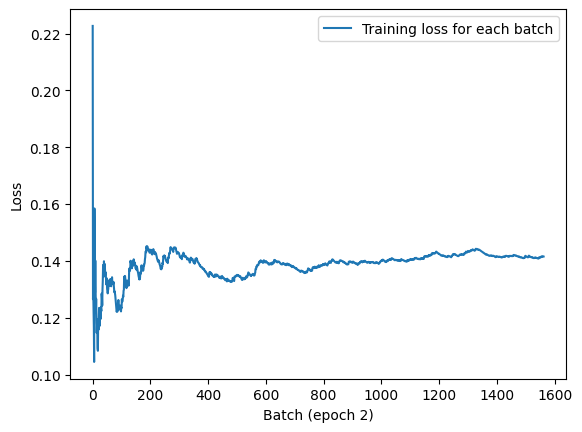

In [30]:
model = get_mnist_model()

model.compile(optimizer="rmsprop",
     loss="sparse_categorical_crossentropy",
     metrics=["accuracy"])

model.fit(train_images, train_labels,
     epochs=3,
     callbacks=[LossHistory()],
     validation_data=(val_images, val_labels))

##  Monitoring and visualization with TensorBoard

In [31]:
model = get_mnist_model()

In [32]:
model.compile(optimizer = 'rmsprop',
             loss='sparse_categorical_crossentropy',
             metrics=['Accuracy'])

In [33]:
tensorboard = keras.callbacks.TensorBoard(
 log_dir="/tensorboard/logs",
)

In [34]:
model.fit(train_images, train_labels,
     epochs=10,
     validation_data=(val_images, val_labels),
     callbacks=[tensorboard])

Epoch 1/10
1563/1563 [==============================] - 40s 24ms/step - loss: 0.2939 - Accuracy: 0.9133 - val_loss: 0.1536 - val_Accuracy: 0.9576
Epoch 2/10
1563/1563 [==============================] - 40s 25ms/step - loss: 0.1652 - Accuracy: 0.9536 - val_loss: 0.1309 - val_Accuracy: 0.9669
Epoch 3/10
1563/1563 [==============================] - 40s 26ms/step - loss: 0.1419 - Accuracy: 0.9634 - val_loss: 0.1086 - val_Accuracy: 0.9727
Epoch 4/10
1563/1563 [==============================] - 40s 26ms/step - loss: 0.1244 - Accuracy: 0.9676 - val_loss: 0.1081 - val_Accuracy: 0.9735
Epoch 5/10
1563/1563 [==============================] - 40s 25ms/step - loss: 0.1185 - Accuracy: 0.9707 - val_loss: 0.1104 - val_Accuracy: 0.9749
Epoch 6/10
1563/1563 [==============================] - 41s 26ms/step - loss: 0.1065 - Accuracy: 0.9741 - val_loss: 0.1222 - val_Accuracy: 0.9752
Epoch 7/10
1563/1563 [==============================] - 37s 24ms/step - loss: 0.1073 - Accuracy: 0.9746 - val_loss: 0.1138 -